# Lab B3

## Matt Wilde

# 3 Spectral lines from the solar atmosphere

## 3.1 Observed Na D line profiles

* **Pull the data that went into making Figure 8 over from ftp://vso.nso.edu/pub/atlas/visatl. Concatenate the files covering the two Na I D lines (sp16900 and sp16950) into a single file, deleting the overlaps.**


In [1]:
# first import everything
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import astropy.constants as const

#use the pretty LaTeX fonts
mpl.rcParams.update({'text.usetex': True})
plt.rc('font', family='serif', size=15)
#mpl.rc('axes.formatter', useoffset=False)

# plt.style.use('ggplot')

* **Write IDL code to read these data. You need the first and third columns (see the README)**

In [2]:
freq, telluric, spec, corrspec = np.loadtxt('NaD.dat', unpack=True)

## 3.2 Na D wavelengths

* **Plot the solar Na I D lines against vacuum wavelength at various dispersions.**

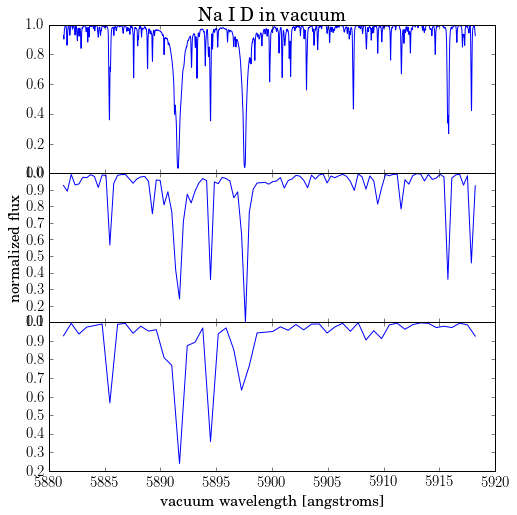

In [3]:
wave = (1/freq)*1e8

fig, ax = plt.subplots(nrows=3, figsize=(8,8), sharex=True)

plt.subplots_adjust(hspace=0.0)
ax[0].plot(wave, spec)
ax[0].set_title('Na I D in vacuum')

ax[1].set_ylabel('normalized flux')


ax[1].plot(wave[::50], spec[::50])
ax[2].set_xlabel('vacuum wavelength [angstroms]')



ax[2].plot(wave[::100], spec[::100])


plt.show()

* **Find the vacuum wavelengths of their minima (use the IDL `where` and `min` functions)**

In [4]:
min1 = wave[spec.argmin()]
tmp = wave[:3800]
min2 = tmp[spec[:3800].argmin()]

In [6]:
print "The Na I D2 and D1 line are at ",min1, min2, "angstroms"

The Na I D2 and D1 line are at  5891.57811281 5897.55475585 angstroms


* **Check that the Na I D wavelengths tabulated in the solar spectrum line list of Moore et al. (1966) (computer-readable at ftp://vso.nso.edu/pub/atlas/linelist/Moore) are $\lambda = 5895.94 \unicode{xC5}$ for Na I D1 and $\lambda = 5889.97 \unicode{xC5}$ for Na I D2. Check the identification of a few blends (other lines) in Figure 8 with the entries in this table.**

        5889.973M *   752.   120.SS       NA 1(D2)    0.00  1

        5895.940M *   564.    91.S        NA 1(D1)    0.00  1        

* **The Astrolib3 routines airtovac and vactoair convert air into vacuum wavelengths and vice versa. A reasonably accurate transformation is also given by **

$$\lambda_{air} = 0.99972683 \lambda_{vac} + 0.0107 - 196.25/\lambda_{vac}$$


**with both $\lambda$s in $\unicode{xC5}$, from Neckel 1999. Use this equation or routine vactoair to plot the Na I D lines **

In [7]:
def vactoair(lam):
    return 0.99972683*lam + 0.0107 - 196.25/lam

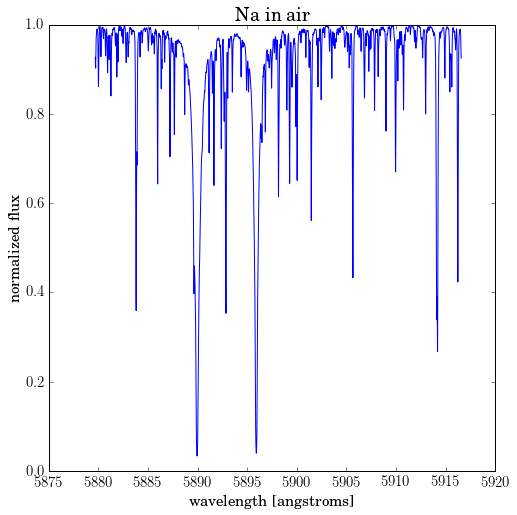

In [8]:
wave_air = vactoair(wave)

fig, ax = plt.subplots(figsize=(8,8))

ax.plot(wave_air, spec)
ax.set_xlabel('wavelength [angstroms]')
ax.set_ylabel('normalized flux')
ax.set_title('Na in air')
plt.show()

## 3.6 Implementation

* **Implement the above into a function that returns the line extinction at all heights of the FALC atmosphere, for example `NaD1_ext(wav,temp,eldens,nhyd,vmicro)`. It is best to make this a set of subroutines that process the atmospheric arrays in one go, without `for ih=0,nh-1 do begin` unrolling because that results in much slower execution.**

In [9]:
def partfuncNaI(t):
    """ 
        NaI partfucntion from Gray (1992)

    """
    theta = 5040./t
    
    cc = np.array([0.30955, -0.17778, 1.10594, -2.42847, 1.70721])
    logU_NaI = cc[0] + cc[1]*np.log10(theta) + cc[2]*np.log10(theta)**2
    logU_NaI = logU_NaI + cc[3]*np.log10(theta)**3 + cc[4]*np.log10(theta)**4
    return 10.**(logU_NaI)


def partfunc(t):
    u = np.zeros(3)
    u[0] = partfuncNaI(t)
    u[1] = 1.
    u[2] = 6.
    return u


def boltz(temp,r,s):
    # n_r,s / N_r
    
    #r = 1 # NaI D1
    #s = 1 # NaI D1
    kev=8.61734e-5 # Boltzmann constant (eV/deg)
    kevT=kev*temp
    u=partfunc(temp)
    keV=8.61734e-5 # Boltzmann constant in ev/deg
    relnrs = 1./u[r-1]*np.exp(-(s-1)/(keV*temp))
    return relnrs

    chiion = np.array([5.139,47.29,71.64])
    
    g_rs = 2
    
    out = g_rs/partfunc(temp) * np.exp(-chiion[r-1]/kevT)
    return out

def saha(temp,eldens,ionstage):
    # N_r+1 / N_r

    kerg=1.380658e-16 # Boltzmann constant (erg K; double precision)
    kev=8.61734e-5 # Boltzmann constant (eV/deg)
    h=6.62607e-27 # Planck constant (erg s)
    elmass=9.109390e-28 # electron mass (g) 
    # kT and electron density
    kevT=kev*temp
    kergT=kerg*temp
    eldens
    chiion = np.array([5.139,47.29,71.64])
    # ionization energies for element E
    u = partfunc(temp) # get partition functions U[0]...u[3]
    u = np.append(u,0) # add estimated fifth value to get N_4 too
    sahaconst = (2*np.pi*elmass*kergT/(h*h))**(1.5) * 2./eldens
    nstage=np.zeros(5)
    # double-precision float array
    nstage[0]=1. # relative fractions only (no abundance)
    for r in range(0,3):
        nstage[r+1] = nstage[r]*sahaconst*u[r+1]/u[r]*np.exp(-chiion[r]/kevT)
        ntotal=np.sum(nstage) # sum all stages = element density
    nstagerel=nstage/ntotal # fractions of element density
    return nstagerel[ionstage-1] # ion stages start at 1, IDL at 0

def sahabolt(temp,eldens,ion,level):
    # compute Saha-Boltzmann populaton n_(r,s)/N for level r,s of E
    # input: temperature, electron pressure, ionization stage, level nr
    return saha(temp,eldens,ion) * boltz(temp,ion,level)

In [11]:
# read in the FALC data
height, tau5, colm, T, vturb, n_Htotal, n_proton, \
    nel, ptot, pgasptot, dens = np.loadtxt('../HW4/falc.dat',skiprows=4, unpack=True)

height = height*1e5

In [12]:
print sahabolt(T[40], nel[40], 1, 1)

3.66211408378e-07


In [13]:
def H(a,v):
    return np.exp(-v**2) + a/(np.sqrt(np.pi)*v**2)

In [14]:
def NaD1_ext(wavs, temp, eldens, nhyd, vmicro, pgas, E):
    
    # wavs = angstrom
    # wav = cm

    #convert wavs from angstroms to cgs
    wav = wavs*1e-8 # cm
    vmicro = vmicro*1e5
    #constants
    e = const.e.gauss.value
    c = const.c.cgs.value
    me = const.m_e.cgs.value
    k = const.k_B.cgs.value
    h = const.h.cgs.value

    # initial constants
    constants = np.sqrt(np.pi)*e**2/(me*c**2)

    #oscillator strength
    f = 0.318 # NaI D1

    # statistical weight
    g_low = 2
    g_up = 2 # NaI D1

    #sodium abundance
    A = 1.74e-6

    # natural broadening
    gamma_rad = 6.67e13*(g_low/g_up)*(f/((wavs*.1)**2)) # s^-1


    # ionization energies from n=1, n=2
    E2 = 3.03399556416 # eV
    E1 = 5.139 # eV

    # van der Waals broadening
    R = 13.6 # rydberg in eV
    Z = 1
    n2_low = R * (Z**2/(E1))
    n2_up = R * (Z**2/(E2))
    r2_low = (n2_low/(2*Z**2))*(5*n2_low + 1)
    r2_up = (n2_up/(2*Z**2))*(5*n2_up - 5)
    logvdW = 6.33 + 0.4*np.log10(r2_up - r2_low) + np.log10(pgas) - 0.7*np.log10(temp)
    gamma_vdW = 10.**(logvdW)

    # total broadening
    gamma = gamma_rad + gamma_vdW
    
    # wing broadening fudge factor
    #E = 1e4
    
    gamma = gamma*E

    #doppler width
    lam0 = 5895.94 # NaD1 Angrstroms in air
    mNa = 22.99 * 1.6605e-24 # g
    
    dopp_width = (lam0*1e-8)/c * np.sqrt(2*k*temp/mNa + vmicro**2)
    a = (wav**2 * gamma) / (4*np.pi*c*dopp_width)
    
    
    
    v = (wav - lam0*1e-8)/dopp_width
    
    """    print 'v = ',v
    print 'a = ',a
    print 'r2_low = ',r2_low
    print 'r2_up = ',r2_up
    print 'n2_low = ',n2_low
    print 'n2_up = ',n2_up
    print 'gamma_vdW = ',gamma_vdW"""

    ion = 1
    level = 1

    alpha_line = constants*wav**2*sahabolt(temp, eldens, ion, level)*nhyd*A*f*(H(a,v)/dopp_width)*(1-np.exp(-h*c/(wav*k*temp)))

    
    return alpha_line

In [18]:
NaD1_ext(5995.94, T[40], nel[40], n_Htotal[40], vturb[40], ptot[40], 1e4)

6.0974035939543008e-18

1.68212275737e-12


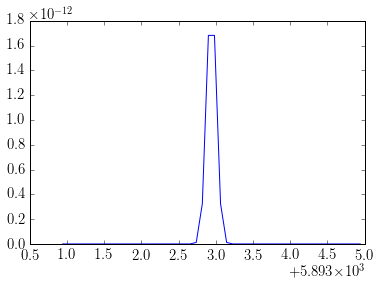

In [19]:
# short_wave = wave_air[(wave_air > 5887) & (wave_air < 5892)][::10]
short_wave = np.linspace(5893.94, 5897.94, 50) #was 500
lam0 = 5895.94
plt.plot(short_wave, NaD1_ext(short_wave, T[40], nel[40], n_Htotal[40], vturb[40], ptot[40],1))

print NaD1_ext(short_wave, T[40], nel[40], n_Htotal[40], vturb[40], ptot[40], 1).max()

## 3.7 Computed Na D1 line profile
 
* **Add the Na I D1 line extinction to the continuous extinction in your integration code from the previous exercise and compute the disk-center Na I D1 profile.**

In [21]:
def exthmin(wavs,temps,eldens):
    """
    H- extinction.
    
    in:  wav = wavelength [Angstrom] (number or array but then others number)
          temp = temperature [K]  (number or array)
          eldens = electron density [electrons cm-3] (number or array)
    out: H-minus bf+ff extinction [cm^2 per neutral hydrogen atom]
          assuming LTE ionization H/H-min
          NB: includes stimulated emission correction already!
    """
    
    k = const.k_B.cgs.value
    h = const.h.cgs.value
    c = const.c.cgs.value
    
    # other parameters
    theta=5040./temps
    elpress=eldens*k*temps

    # evaluate H-min bound-free per H-min ion = Gray (8.11)
    # his alpha = my sigma in NGSB/AFYC (per particle without stimulated)
    sigmabf = 1.99654 -1.18267e-5*wavs +2.64243e-6*wavs**2 -4.40524e-10*wavs**3 \
            +3.23992e-14*wavs**4 -1.39568e-18*wavs**5 + 2.78701e-23*wavs**6
    sigmabf=sigmabf*1e-18  # cm^2 per H-min ion
    
    if type(wavs) == np.ndarray:
        sigmabf[wavs > 16444] = 0. # H-min ionization limit 
    else:
        if wavs > 16444:
            sigmabf = 0.0
        
    # convert into bound-free per neutral H atom assuming Saha = Gray p135
    # units: cm2 per neutral H atom in whatever level (whole stage)
    graysaha=4.158e-10*elpress*np.power(theta,2.5)*np.power(10.,(0.754*theta)) # Gray (8.12)
    kappabf=sigmabf*graysaha  # per neutral H atom
    kappabf=kappabf*(1.-np.exp(-h*c/(wavs*1.0e-8*k*temps))) 
    # correct stimulated emission

    # check Gray's Saha-Boltzmann with AFYC (edition 1999) p168
    # logratio=-0.1761-alog10(elpress)+alog10(2.)+2.5*alog10(temp)-theta*0.754
    # print,'Hmin/H ratio=',1/(10.^logratio) ; OK, same as Gray factor SB

    # evaluate H-min free-free including stimulated emission = Gray p136
    lwav=np.log10(wavs)
    f0 =  -2.2763 -1.6850*lwav +0.76661*lwav**2 -0.0533464*lwav**3
    f1 =  15.2827 -9.2846*lwav +1.99381*lwav**2 -0.142631*lwav**3
    f2 = -197.789 +190.266*lwav -67.9775*lwav**2 +10.6913*lwav**3 -0.625151*lwav**4
    ltheta=np.log10(theta)
    kappaff = 1.0e-26*elpress*np.power(10,(f0+f1*ltheta+f2*ltheta**2))   # Gray (8.13)

    return kappabf+kappaff

import astropy.units as u
def planck(temps, wavs):
    
    wav = wavs*u.micrometer # to cm
    c = const.c.cgs
    h = const.h.cgs
    k = const.k_B.cgs
    temp2 = temps*u.K
    b = (2*h*c**2/wav**5) / (np.exp(((h*c)/(wav*k*temp2))) - 1)
    # b.to(u.erg / u.cm**2 / u.s / u.Hz,
                    #equivalencies=u.spectral_density(0.8*u.micrometer))
    
    return b.to(u.erg / u.cm**2 / u.s / u.micrometer, equivalencies=u.spectral_density(wav))


def emergent(wl, heights, temp, E):
    # emergent intensity at wavelength wl (micron)

    # redefine variables to be consistent with code
    nhyd = n_Htotal # from FALC
    nprot = n_proton
    nh = n_Htotal

    ext = np.zeros_like(nh)
    tau = np.zeros_like(nh)
    integrand = np.zeros_like(nh)
    contfunc = np.zeros_like(nh)
    ints=0.
    hint=0.

    for ih in range(1,len(n_Htotal)):
        tot_ext = exthmin(wl*1e4,temp[ih],nel[ih])*(nhyd[ih] - nprot[ih]) 
        tot_ext += 0.664e-24*nel[ih] 
        tot_ext += NaD1_ext(wl*1e4, temp[ih], nel[ih], n_Htotal[ih], vturb[ih], ptot[ih], E)
        #ext[ih] = exthmin(wl*1e4,temp[ih],nel[ih])*(nhyd[ih] - nprot[ih]) + 0.664e-24*nel[ih]
        ext[ih] = tot_ext
        tau[ih] = tau[ih-1]+0.5*(ext[ih]+ext[ih-1])*(heights[ih-1]-heights[ih])
        integrand[ih] = planck(temp[ih],wl).value*np.exp(-tau[ih])
        ints = ints + 0.5*(integrand[ih]+integrand[ih-1])*(tau[ih]-tau[ih-1])
        hint = hint + height[ih]*0.5*(integrand[ih]+integrand[ih-1])*(tau[ih]-tau[ih-1])
        contfunc[ih] = integrand[ih]*ext[ih]

    hmean=hint/ints
    
    return ints, contfunc, hmean, tau


def emergent_Hmin(wl, heights, temp):
    # emergent intensity at wavelength wl (micron)

    # redefine variables to be consistent with code
    nhyd = n_Htotal # from FALC
    nprot = n_proton
    nh = n_Htotal

    ext = np.zeros_like(nh)
    tau = np.zeros_like(nh)
    integrand = np.zeros_like(nh)
    contfunc = np.zeros_like(nh)
    ints=0.
    hint=0.

    for ih in range(1,len(n_Htotal)):
        ext[ih] = exthmin(wl*1e4,temp[ih],nel[ih])*(nhyd[ih] - nprot[ih]) + 0.664e-24*nel[ih]
        tau[ih] = tau[ih-1]+0.5*(ext[ih]+ext[ih-1])*(heights[ih-1]-heights[ih])
        integrand[ih] = planck(temp[ih],wl).value*np.exp(-tau[ih])
        ints = ints + 0.5*(integrand[ih]+integrand[ih-1])*(tau[ih]-tau[ih-1])
        hint = hint + height[ih]*0.5*(integrand[ih]+integrand[ih-1])*(tau[ih]-tau[ih-1])
        contfunc[ih] = integrand[ih]*ext[ih]

    hmean=hint/ints
    
    return ints, contfunc, hmean, tau

In [52]:
E = np.array([1,5])

short_wave = np.linspace(5893.94, 5897.94, 500) #was 500
em_intense_arr = np.zeros([short_wave.size,E.size])
em_intense_Hmin_arr = np.zeros_like(short_wave)

for j,ee in enumerate(E):
    for i,w in enumerate(short_wave):
        em_intense_arr[i,j], tmp, tmp, tmp = emergent(w/1e4, height, T, ee)
        em_intense_Hmin_arr[i], tmp, tmp, tmp = emergent_Hmin(w/1e4, height, T)

In [53]:
print short_wave.shape, em_intense_arr.shape


(500,) (500, 2)


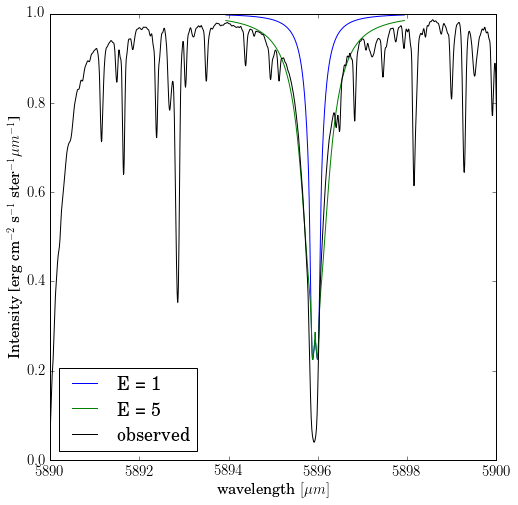

In [56]:
fig, ax =  plt.subplots(figsize=(8,8))

for i,ee in enumerate(E):
    ax.plot(short_wave, em_intense_arr[:,i]/em_intense_Hmin_arr, label=r'E = {}'.format(ee))
ax.plot(wave_air, spec, color='black', label=r'observed')

flux_unit = r'Intensity [erg cm$^{-2}$ s$^{-1}$ ster$^{-1} \mu m^{-1}$]'

ax.set_xlabel(r'wavelength $[\mu m]$')
ax.set_ylabel(flux_unit)
ax.set_xlim(5890, 5900)
ax.legend(loc='best')

plt.savefig('final_NaID1_withE.png')
plt.show()

* **Compare the computed line profile to the observed line profile and discuss the differences. Explain why your computed profile has a line-center reversal.**

> The computed Na I D$_{1}$ line has a line-center reversal since we are assuming LTE and the Na I D lines are strong scatterers, thus in NLTE. The line center reversal is due to the line center "feeling" the chromospheric temperature rise since we are assuming LTE. In the NLTE case, the line is a strong scatterer and would not see the temperature reversal, scattering its way out of the atmosphere. 

* **Traditionally, stellar abundance determiners vary a collisional enhancement factor E by which ,vdW is multiplied in ad-hoc “fudge-factor” fashion in order to obtain a better fit of the line wings. You may try such, or better broadening recipes from Paul Barklem at http://www.astro.uu.se/˜barklem.**

> Using a fudge factor of $E = 5$ gives a line in much better agreement with the observed line wings.